# Environment setup

In [0]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Copy the dataset from Google Drive to local

!cp "/content/gdrive/My Drive/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

In [0]:
# Import libraries

%tensorflow_version 1.x
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

# Data pre-processing

In [0]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

The data is prepared following these steps:


1.   Import the training and testing data from numpy arrays
2.   Remove the images and labels related to baseline patches (even indices in the arrays)
3.   Adjust the labels for the classification problem, so that 0 corresponds to 'benign mass', 1 to 'malignant mass', 2 to 'bening calcification' and 3 to 'malignant calcification'
4.   Convert the labels to categorical format, required by the categorical_crossentropy loss function
5.   Normalize the pixels to be in the range (0-1) floating point
6.   Shuffle the training set (and labels accordingly, of course)
7.   Split the training data into 'training' and 'validation' subsets
8.   Build Keras generators for training and validation data. Note that data augmentation is used from the beginning, as its value was proven in the previous notebook (Scratch_CNN_2_class)


In [0]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

Train size: 2676 	 Test size: 336
Image size: 150x150


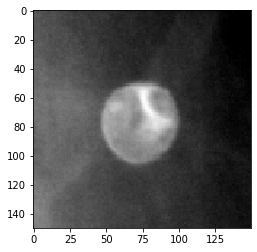

Label: [0. 0. 1. 0.]


In [0]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

# Classification

The task is quite similar to the one addressed in another notebook (Scratch_CNN_2_class), but slightly more complex because here are 4 classes instead than 2. Not only it is important to distinguish between masses and calcifications, but also to diagnose whether the abnormality is benign or malignant.

## Experiment 1

The model that achieved the best performance in the two-class classification is a good starting point for sure, since both tasks partially overlap and they work on the same dataset.
That CNN had an accuracy above 88\% on the test set.
Of course, some modifications are required, especially in the output layer, because the problem is now a multiclass classification: 4 softmax neurons replace the old sigmoid unit.
Likewise, the loss function is now the categorical crossentropy, a generalized version of binary crossentropy.

In [0]:
# Model 1

model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(48, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(4, activation='softmax'))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 256)      

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_1_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_1.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_1 = model_1.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_1, 'model_1_4cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/500
 4/16 [======>.......................] - ETA: 2s - loss: 1.3598 - acc: 0.3555
Epoch 00001: val_loss improved from inf to 1.36900, saving model to model_1_4cl_best.h5
16/16 [==============================] - 6s 348ms/step - loss: 1.5989 - acc: 0.3294 - val_loss: 1.3690 - val_acc: 0.3514
Epoch 2/500
 4/16 [======>.......................] - ETA: 3s - loss: 1.3710 - acc: 0.3535
Epoch 00002: val_loss did not improve from 1.36900
16/16 [==============================] - 5s 294ms/step - loss: 1.3790 - acc: 0.3438 - val_loss: 1.3781 - val_acc: 0.3514
Epoch 3/500
 4/16 [======>.......................] - ETA: 3s - loss: 1.3638 - acc: 0.3535
Epoch 00003: val_loss improved from 1.36900 to 1.36840, saving model to model_1_4cl_best.h5
16/16 [==============================] - 5s 307ms/step - loss: 1.3728 - acc: 0.3408 - val_loss: 1.3684 - val_acc: 0.3514
Epoch 4/500
 4/16 [======>.......................] - ETA: 4s - loss: 1.3505 - acc: 0.3535
Epoch 00004: val_loss did not improve from 1.3

In [0]:
# History of accuracy and loss
tra_loss_1 = history_1.history['loss']
tra_acc_1 = history_1.history['acc']
val_loss_1 = history_1.history['val_loss']
val_acc_1 = history_1.history['val_acc']

# Total number of epochs training
epochs_1 = range(1, len(tra_acc_1)+1)
end_epoch_1 = len(tra_acc_1)

# Epoch when reached the validation loss minimum
opt_epoch_1 = val_loss_1.index(min(val_loss_1)) + 1

# Loss and accuracy on the validation set
end_val_loss_1 = val_loss_1[-1]
end_val_acc_1 = val_acc_1[-1]
opt_val_loss_1 = val_loss_1[opt_epoch_1-1]
opt_val_acc_1 = val_acc_1[opt_epoch_1-1]

# Loss and accuracy on the test set
opt_model_1 = models.load_model('model_1_4cl_best.h5')
test_loss_1, test_acc_1 = model_1.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_1, opt_test_acc_1 = opt_model_1.evaluate(test_images, test_labels, verbose=False)
opt_pred_1 = opt_model_1.predict([test_images, test_labels])
pred_classes_1 = np.rint(opt_pred_1)

print("Model 1\n")

print("Epoch [end]: %d" % end_epoch_1)
print("Epoch [opt]: %d" % opt_epoch_1)
print("Valid accuracy [end]: %.4f" % end_val_acc_1)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_1)
print("Test accuracy [end]:  %.4f" % test_acc_1)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_1)
print("Valid loss [end]: %.4f" % end_val_loss_1)
print("Valid loss [opt]: %.4f" % opt_val_loss_1)
print("Test loss [end]:  %.4f" % test_loss_1)
print("Test loss [opt]:  %.4f" % opt_test_loss_1)

print(classification_report(test_labels, pred_classes_1, digits=4))

Model 1

Epoch [end]: 288
Epoch [opt]: 208
Valid accuracy [end]: 0.6280
Valid accuracy [opt]: 0.6355
Test accuracy [end]:  0.5893
Test accuracy [opt]:  0.5774
Valid loss [end]: 0.8367
Valid loss [opt]: 0.7709
Test loss [end]:  0.9490
Test loss [opt]:  0.9402
              precision    recall  f1-score   support

           0     0.6812    0.4159    0.5165       113
           1     0.4750    0.2879    0.3585        66
           2     0.7500    0.6226    0.6804       106
           3     0.4783    0.4314    0.4536        51

   micro avg     0.6337    0.4583    0.5320       336
   macro avg     0.5961    0.4395    0.5022       336
weighted avg     0.6316    0.4583    0.5276       336
 samples avg     0.4583    0.4583    0.4583       336



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


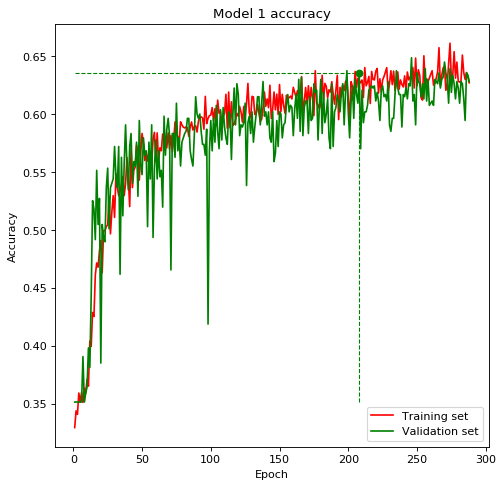

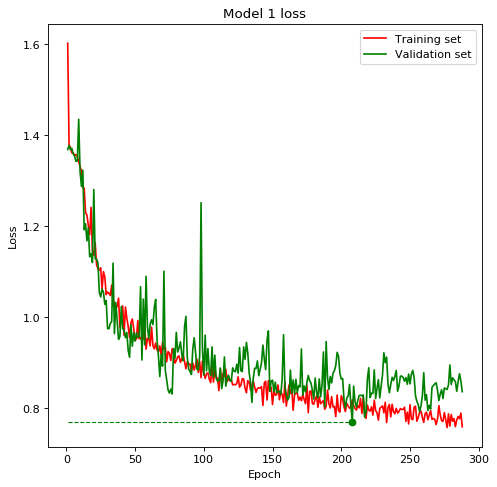

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_acc_1, 'r', label='Training set')
plt.plot(epochs_1, val_acc_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_acc_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_acc_1), opt_val_acc_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_loss_1, 'r', label='Training set')
plt.plot(epochs_1, val_loss_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_loss_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_loss_1), opt_val_loss_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

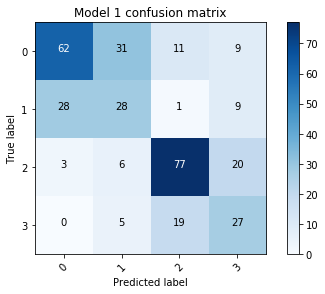

In [0]:
pred_1_classes = opt_model_1.predict_classes(test_images)
confusion_mtx = confusion_matrix(test_labels_raw, pred_1_classes) 
plot_confusion_matrix(confusion_mtx, classes=range(4), title='Model 1 confusion matrix')

**Result**: the network obtained a 57.7% accuracy on the test set. This value is significantly lower than the almost 88% achieved in the 2-class classification task, but it is an obvious consequence of the increased number of classes. Now it is sufficient to mispredict the type OR the malignancy to consider that sample classified wrong. 
The confusion matrix provides very useful information here. Remembering how the labels were mapped to classes (documented [here](https://colab.research.google.com/drive/1frEEh7C_EQSmSiFS7FygFKI0eqybFmNb#scrollTo=u_Q0cPtr3jJt&line=11&uniqifier=1)), one may observe that 44 images were assigned the wrong type (mass/calc), that is corresponds 13.1% of the samples. In other words, ignoring the malignancy, that corresponds to a 86.3% accuracy, in line with the results achieved by the pure 2-class classifier.
It is worth to point out that most of the mistakes are indeed due to benign/malignant misclassification, rather than mass/calcification swapping.
Apparently, the task of predicting the harmfulness is inherently a more difficult task than identifying the type of abnormality.
Finally, a moderate overfitting is noticeable at the end of the training.

## Experiment 2

The second model is shallower, but with twice the filters than before in the corresponding layers.
Alternatively, it can be seen as 
a clone of the previous where the first conv block has been skipped.
The hypothesis to verify is that more filters in early convolutional stages can help achieving a better accuracy.

Specifically:

*   Three conv2D layer with 64, 128, 256 filters
*   The last FC layer has few more neurons (64, previously was 48) to cope with the increased filters







In [0]:
# Model 2

model_2 = models.Sequential()
model_2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu')
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(256, (3, 3), activation='relu')
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(4, activation='softmax'))

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 17, 17, 256)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 73984)            

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_2_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_2.compile(optimizer=RMSprop(learning_rate=0.001, decay=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_2 = model_2.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_2, 'model_2_4cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/500
 4/16 [======>.......................] - ETA: 3s - loss: 1.9218 - acc: 0.3477
Epoch 00001: val_loss improved from inf to 1.89228, saving model to model_2_4cl_best.h5
16/16 [==============================] - 7s 445ms/step - loss: 2.0709 - acc: 0.3299 - val_loss: 1.8923 - val_acc: 0.3514
Epoch 2/500
 4/16 [======>.......................] - ETA: 3s - loss: 1.3677 - acc: 0.3477
Epoch 00002: val_loss improved from 1.89228 to 1.36348, saving model to model_2_4cl_best.h5
16/16 [==============================] - 6s 358ms/step - loss: 1.4298 - acc: 0.3315 - val_loss: 1.3635 - val_acc: 0.3514
Epoch 3/500
 4/16 [======>.......................] - ETA: 3s - loss: 1.3633 - acc: 0.3477
Epoch 00003: val_loss improved from 1.36348 to 1.35604, saving model to model_2_4cl_best.h5
16/16 [==============================] - 6s 361ms/step - loss: 1.3701 - acc: 0.3559 - val_loss: 1.3560 - val_acc: 0.3514
Epoch 4/500
 4/16 [======>.......................] - ETA: 4s - loss: 1.3573 - acc: 0.3477
Epoch

In [0]:
# History of accuracy and loss
tra_loss_2 = history_2.history['loss']
tra_acc_2 = history_2.history['acc']
val_loss_2 = history_2.history['val_loss']
val_acc_2 = history_2.history['val_acc']

# Total number of epochs training
epochs_2 = range(1, len(tra_acc_2)+1)
end_epoch_2 = len(tra_acc_2)

# Epoch when reached the validation loss minimum
opt_epoch_2 = val_loss_2.index(min(val_loss_2)) + 1

# Loss and accuracy on the validation set
end_val_loss_2 = val_loss_2[-1]
end_val_acc_2 = val_acc_2[-1]
opt_val_loss_2 = val_loss_2[opt_epoch_2-1]
opt_val_acc_2 = val_acc_2[opt_epoch_2-1]

# Loss and accuracy on the test set
opt_model_2 = models.load_model('model_2_4cl_best.h5')
test_loss_2, test_acc_2 = model_2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_2, opt_test_acc_2 = opt_model_2.evaluate(test_images, test_labels, verbose=False)

print("Model 2\n")

print("Epoch [end]: %d" % end_epoch_2)
print("Epoch [opt]: %d" % opt_epoch_2)
print("Valid accuracy [end]: %.4f" % end_val_acc_2)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_2)
print("Test accuracy [end]:  %.4f" % test_acc_2)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_2)
print("Valid loss [end]: %.4f" % end_val_loss_2)
print("Valid loss [opt]: %.4f" % opt_val_loss_2)
print("Test loss [end]:  %.4f" % test_loss_2)
print("Test loss [opt]:  %.4f" % opt_test_loss_2)

Model 2

Epoch [end]: 500
Epoch [opt]: 483
Valid accuracy [end]: 0.6336
Valid accuracy [opt]: 0.6542
Test accuracy [end]:  0.6071
Test accuracy [opt]:  0.6131
Valid loss [end]: 0.8131
Valid loss [opt]: 0.7440
Test loss [end]:  0.9278
Test loss [opt]:  0.9047


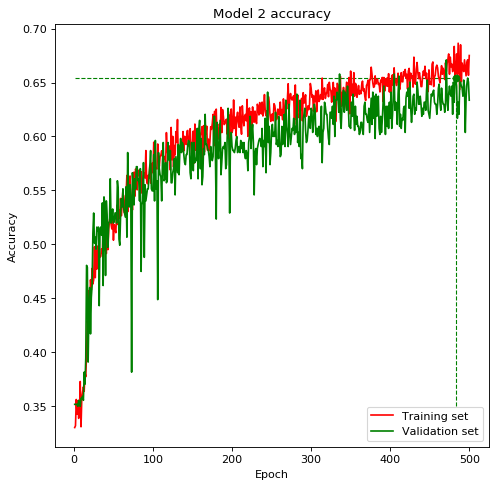

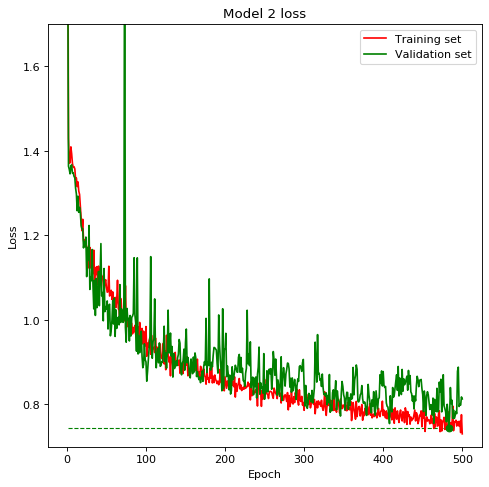

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_acc_2, 'r', label='Training set')
plt.plot(epochs_2, val_acc_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_acc_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_acc_2), opt_val_acc_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.7, 1.7)
plt.plot(epochs_2, tra_loss_2, 'r', label='Training set')
plt.plot(epochs_2, val_loss_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_loss_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_loss_2), opt_val_loss_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend();

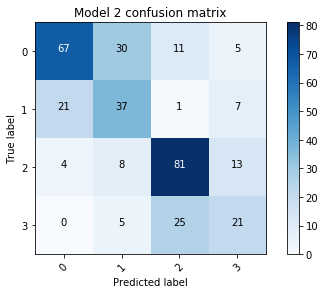

In [0]:
pred_2_classes = opt_model_2.predict_classes(test_images)
confusion_mtx = confusion_matrix(test_labels_raw, pred_2_classes) 
plot_confusion_matrix(confusion_mtx, classes=range(4), title='Model 2 confusion matrix')

**Result**: 41 samples were assigned the wrong abnormality type, that is a 87.8% accuracy in predicting that feature. On the other side, 30.6% were incorrectly classified as benign or malignant, so the harmfulness prediction accuracy is only 69.4%.
The overall accuracy is better than in the previous model (61.3% vs 57.7%). Even after a very long training the loss was still decreasing; increasing the learning rate would be a risky move here, since the evolution is already quite noisy.

## Experiment 3

What about another convolutional block? Does it help distinguishing between malignant and benign bodies? The next experiment provides an answer to these question, by training a deeper model with an extra Conv2D layer with 512 features.

In [0]:
# Model 3

model_3 = models.Sequential()
model_3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(4, activation='softmax'))

model_3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 15, 15, 512)      

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_3_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_3.compile(optimizer=RMSprop(learning_rate=0.001, decay=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_3 = model_3.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_3, 'model_3_4cl_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/500
 5/16 [========>.....................] - ETA: 2s - loss: 1.3707 - acc: 0.3514
Epoch 00001: val_loss improved from inf to 1.37069, saving model to model_3_4cl_best.h5
16/16 [==============================] - 9s 537ms/step - loss: 1.9075 - acc: 0.3060 - val_loss: 1.3707 - val_acc: 0.3514
Epoch 2/500
 4/16 [======>.......................] - ETA: 3s - loss: 1.3746 - acc: 0.3555
Epoch 00002: val_loss did not improve from 1.37069
16/16 [==============================] - 6s 352ms/step - loss: 1.3862 - acc: 0.3438 - val_loss: 1.3774 - val_acc: 0.3514
Epoch 3/500
 4/16 [======>.......................] - ETA: 3s - loss: 1.3575 - acc: 0.3613
Epoch 00003: val_loss improved from 1.37069 to 1.36982, saving model to model_3_4cl_best.h5
16/16 [==============================] - 6s 376ms/step - loss: 1.3799 - acc: 0.3467 - val_loss: 1.3698 - val_acc: 0.3514
Epoch 4/500
 4/16 [======>.......................] - ETA: 4s - loss: 1.3592 - acc: 0.3672
Epoch 00004: val_loss improved from 1.36982 to

In [0]:
# History of accuracy and loss
tra_loss_3 = history_3.history['loss']
tra_acc_3 = history_3.history['acc']
val_loss_3 = history_3.history['val_loss']
val_acc_3 = history_3.history['val_acc']

# Total number of epochs training
epochs_3 = range(1, len(tra_acc_3)+1)
end_epoch_3 = len(tra_acc_3)

# Epoch when reached the validation loss minimum
opt_epoch_3 = val_loss_3.index(min(val_loss_3)) + 1

# Loss and accuracy on the validation set
end_val_loss_3 = val_loss_3[-1]
end_val_acc_3 = val_acc_3[-1]
opt_val_loss_3 = val_loss_3[opt_epoch_3-1]
opt_val_acc_3 = val_acc_3[opt_epoch_3-1]

# Loss and accuracy on the test set
opt_model_3 = models.load_model('model_3_4cl_best.h5')
test_loss_3, test_acc_3 = model_3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_3, opt_test_acc_3 = opt_model_3.evaluate(test_images, test_labels, verbose=False)
opt_pred_3 = opt_model_3.predict([test_images, test_labels])
pred_classes_3 = np.rint(opt_pred_3)

print("Model 3\n")

print("Epoch [end]: %d" % end_epoch_3)
print("Epoch [opt]: %d" % opt_epoch_3)
print("Valid accuracy [end]: %.4f" % end_val_acc_3)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_3)
print("Test accuracy [end]:  %.4f" % test_acc_3)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_3)
print("Valid loss [end]: %.4f" % end_val_loss_3)
print("Valid loss [opt]: %.4f" % opt_val_loss_3)
print("Test loss [end]:  %.4f" % test_loss_3)
print("Test loss [opt]:  %.4f" % opt_test_loss_3)

print(classification_report(test_labels, pred_classes_3, digits=4))

Model 3

Epoch [end]: 286
Epoch [opt]: 206
Valid accuracy [end]: 0.6131
Valid accuracy [opt]: 0.5981
Test accuracy [end]:  0.6190
Test accuracy [opt]:  0.6101
Valid loss [end]: 0.9257
Valid loss [opt]: 0.8071
Test loss [end]:  0.9292
Test loss [opt]:  0.9422
              precision    recall  f1-score   support

           0     0.7000    0.4336    0.5355       113
           1     0.5333    0.1212    0.1975        66
           2     0.7396    0.6698    0.7030       106
           3     0.5714    0.3137    0.4051        51

   micro avg     0.6890    0.4286    0.5284       336
   macro avg     0.6361    0.3846    0.4603       336
weighted avg     0.6602    0.4286    0.5022       336
 samples avg     0.4286    0.4286    0.4286       336



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


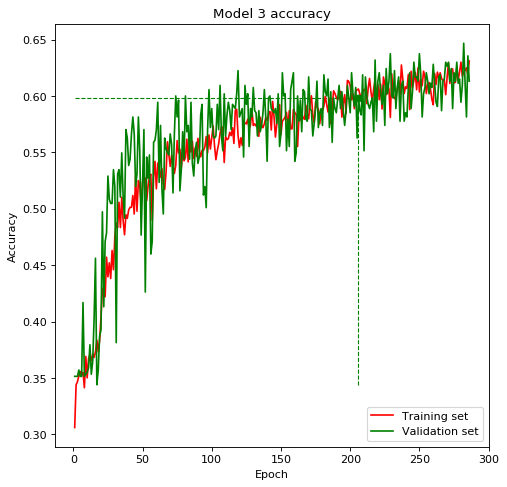

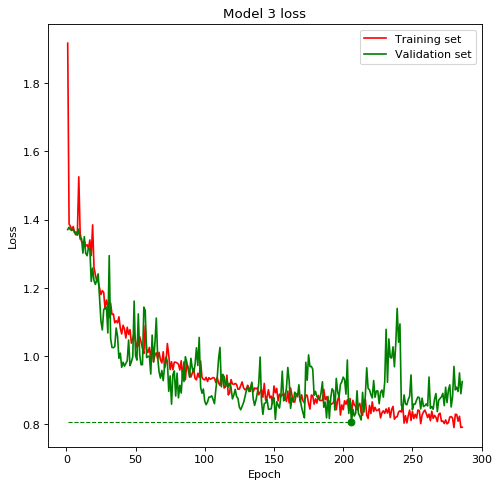

In [0]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_acc_3, 'r', label='Training set')
plt.plot(epochs_3, val_acc_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_acc_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_acc_3), opt_val_acc_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_loss_3, 'r', label='Training set')
plt.plot(epochs_3, val_loss_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_loss_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_loss_3), opt_val_loss_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend();

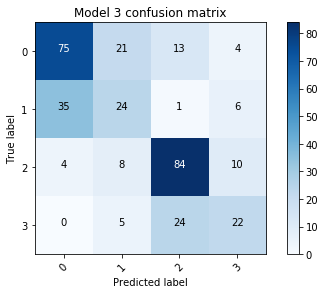

In [0]:
pred_3_classes = opt_model_3.predict_classes(test_images)
confusion_mtx = confusion_matrix(test_labels_raw, pred_3_classes) 
plot_confusion_matrix(confusion_mtx, classes=range(4), title='Model 3 confusion matrix')

**Result**: after more than 200 epoch, the NN reached a classification accuracy of 61\%.
It is interesting to note how the model is more prone to classify malignant abnormalities as benign rather than viceversa. In a medical context it could be a desirable feature, since false negatives are potentially more harmful than false positives.